In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["DATA_PATH"] = "../assets/"

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from collections import namedtuple, deque
from queue import PriorityQueue
from src.game.wrapped_flappy_bird import GameState
from src.models.DoubleDQN import DoubleDQN, QualityEstimator, policy

from torch.utils.tensorboard import SummaryWriter

import random
import pygame
from pygame.locals import (
    QUIT,
    KEYDOWN,
    K_ESCAPE,
    K_SPACE,
    K_UP
)

pygame 2.4.0 (SDL 2.26.4, Python 3.10.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
writer = SummaryWriter()

In [4]:
config = {
    "sessions_num": 10000,
    "gamma": 0.99,
    "lr": 1e-3,
    "state_dim": 4,
    "action_dim": 2,
    "hid_dim": [64, 128, 128, 64],
    "epsion": 0.5,
    "temperature": 1,
    "batch_size": 100,
    "grad_clip": 50,
    "memory_size": 1000,
    "model_save_path": "../models/"
}

MODEL_SAVE_PATH = config["model_save_path"]
MEMORY_SIZE = config["memory_size"]
GRAD_CLIP = config["grad_clip"]
BATCH_SIZE = config["batch_size"]
LR = config["lr"]
GAMMA = config["gamma"]
EPS = config["epsion"]
TEMP = config["temperature"]
SESSIONS_NUM = config["sessions_num"]

In [5]:
Transition = namedtuple(
    'Transition',
    ('state', 'action', 'next_state', 'reward')
)
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [6]:
def get_state(terminal):
    return torch.tensor(
        list(terminal.state.values()),
        dtype=torch.float32
    ).view(1, -1).to(DEVICE)

In [7]:
def optimize_model(model, target_model, memory, optimizer):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=DEVICE, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    
    
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    state_action_values = model(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=DEVICE)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_model(non_final_next_states).max(1)[0]
        
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(model.parameters(), GRAD_CLIP)
    optimizer.step()

In [8]:
action_terminal = GameState()

In [9]:
model_qa = QualityEstimator(
    config["state_dim"],
    config["action_dim"],
    config["hid_dim"]
).to(DEVICE)

model_qb = QualityEstimator(
    config["state_dim"],
    config["action_dim"],
    config["hid_dim"]
).to(DEVICE)

optimizer_qa = optim.Adam(model_qa.parameters(), lr=LR)
optimizer_qb = optim.Adam(model_qb.parameters(), lr=LR)
criterion = nn.SmoothL1Loss()

In [10]:
total_rewards = []
memory = ReplayMemory(MEMORY_SIZE)

for session_idx in tqdm(range(SESSIONS_NUM)):
    terminal = False
    input_action = 0
    total_reward = 0.0
    max_score = 0
    
    _, reward, terminal = action_terminal.frame_step(input_action)
    state = get_state(action_terminal)
    
    while not terminal:
        if np.random.randint(0, 2) == 0:
            action, predicted_reward = policy(model_qa, state, epsilon=max((EPS - EPS / SESSIONS_NUM * session_idx * 3), 1e-3))
            _, reward, terminal = action_terminal.frame_step(action)
            reward = torch.tensor([reward], device=DEVICE)
            next_state = get_state(action_terminal)
            
            memory.push(state, action, next_state, reward)
            
            state = next_state

            optimize_model(model_qa, model_qb, memory, optimizer_qa)
        else:
            action, predicted_reward = policy(model_qb, state, epsilon=max((EPS - EPS / SESSIONS_NUM * session_idx * 3), 1e-3))
            _, reward, terminal = action_terminal.frame_step(action)
            reward = torch.tensor([reward], device=DEVICE)
            next_state = get_state(action_terminal)
            
            memory.push(state, action, next_state, reward)
            
            state = next_state

            optimize_model(model_qb, model_qa, memory, optimizer_qb)
        # model_qa.zero_grad()
        # model_qb.zero_grad()
        
        # if np.random.randint(0, 2) == 0:
        #     action, predicted_reward = policy(model_qa, state, epsilon=max((EPS - EPS / SESSIONS_NUM * session_idx * 3), 1e-2))
            
        #     _, reward, terminal = action_terminal.frame_step(action)
        #     next_state = torch.tensor(list(action_terminal.state.values()), dtype=torch.float32)
            
        #     with torch.no_grad():
        #         predicted_next_reward = torch.max(model_qb(next_state))
            
        #     state = next_state
            
        #     loss = criterion(predicted_reward, reward + GAMMA * predicted_next_reward)
        #     loss.backward()
        #     model_qb.zero_grad()
            
        # else:
        #     action, predicted_reward = policy(model_qb, state, epsilon=max((EPS - EPS / SESSIONS_NUM * session_idx * 3), 1e-2))     
        #     _, reward, terminal = action_terminal.frame_step(action)
        #     state = torch.tensor(list(action_terminal.state.values()), dtype=torch.float32)
            
        #     with torch.no_grad():
        #         predicted_next_reward = torch.max(model_qa(state))
            
        #     loss = criterion(predicted_reward, reward + GAMMA * predicted_next_reward)
        #     loss.backward()
        #     model_qa.zero_grad()
            

        # optimizer_qa.step()
        # optimizer_qb.step()
        
        total_reward += reward
        max_score = max(max_score, action_terminal.score)
        
    if (session_idx + 1) % 100 == 0:
        torch.save(model_qa, MODEL_SAVE_PATH+"model_qa")
        torch.save(model_qb, MODEL_SAVE_PATH+"model_qb")
    
    total_rewards += [total_reward]    
    writer.add_scalar(f"Total reward {config=}", total_reward, session_idx)
    writer.add_scalar(f"Max score {config=}", max_score, session_idx)

  0%|          | 0/10000 [00:00<?, ?it/s]

c:\max\proga\grishin_ml\flappybirdsolo\src\models\DoubleDQN.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(action, dtype=torch.long).view(1, 1).to(state.device), torch.tensor(predicted_actions_rewards[action], dtype=torch.float32).view(1, 1).to(state.device)


: 

: 

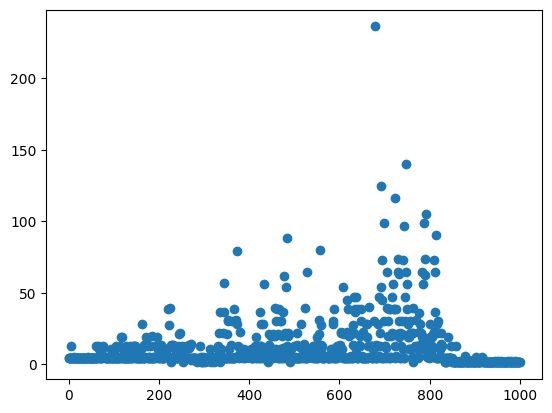

In [48]:
# total_rewards = [rew.cpu().detach() for rew in total_rewards]
# plt.scatter(range(len(total_rewards)), total_rewards)

In [8]:
# action_terminal = GameState()
# for _ in range(10):
#     terminal = False
#     while not terminal:
#         # input_actions[0] == 1: do nothing
#         # input_actions[1] == 1: flap the bird
#         action = 0
#         for event in pygame.event.get():
#             if event.type == KEYDOWN and (event.key == K_SPACE or event.key == K_UP):
#                 action = 1

#         state = torch.tensor(list(action_terminal.state.values()), dtype=torch.float32)
#         _, reward, terminal = action_terminal.frame_step(action)
#         print(f"{state}")
#         print(f"{action}")
#         print(f"{reward}")
        

tensor([244.,   0., 288., 240.])
0
0.1
tensor([245.,   1., 284., 240.])
0
0.1
tensor([247.,   2., 280., 240.])
0
0.1
tensor([250.,   3., 276., 240.])
0
0.1
tensor([254.,   4., 272., 240.])
0
0.1
tensor([259.,   5., 268., 240.])
0
0.1
tensor([265.,   6., 264., 240.])
0
0.1
tensor([272.,   7., 260., 240.])
0
0.1
tensor([280.,   8., 256., 240.])
0
0.1
tensor([289.,   9., 252., 240.])
0
0.1
tensor([299.,  10., 248., 240.])
0
0.1
tensor([309.,  10., 244., 240.])
0
0.1
tensor([319.,  10., 240., 240.])
0
0.1
tensor([329.,  10., 236., 240.])
0
0.1
tensor([339.,  10., 232., 240.])
0
0.1
tensor([349.,  10., 228., 240.])
0
0.1
tensor([359.,  10., 224., 240.])
0
0.1
tensor([369.,  10., 220., 240.])
0
0.1
tensor([379.,  10., 216., 240.])
0
-0.5
tensor([244.,   0., 288., 260.])
0
0.1
tensor([245.,   1., 284., 260.])
0
0.1
tensor([247.,   2., 280., 260.])
0
0.1
tensor([250.,   3., 276., 260.])
0
0.1
tensor([254.,   4., 272., 260.])
0
0.1
tensor([259.,   5., 268., 260.])
0
0.1
tensor([265.,   6., 264.